#Libraries

In [0]:
import gensim , random
import numpy as np
import matplotlib.pyplot as plt

#3rd party libraries installation for colaboratory
!pip install wikipedia
!pip install Wikipedia-API

import doc_utils #thesis library

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


#Data extraction and cleaning

In [0]:
wiki_topic_defs_full = doc_utils.concurrentGetWikiFullPage(topics_list = doc_utils.ALL_TOPICS)
wiki_test_data, n_test_samples = doc_utils.concurrentGetAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

Obtaining full wikipedia page for the topic: Chemical engineering. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Biomedical engineering. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Civil engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Mechanical engineering. (Definition of Class #[4])Obtaining full wikipedia page for the topic: Electrical engineering. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Aerospace engineering. (Definition of Class #[5])

Obtaining full wikipedia page for the topic: Software engineering. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Industrial engineering. (Definition of Class #[7])
Obtaining full wikipedia page for the topic: Computer engineering. (Definition of Class #[8])
Retrieved 32 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 56 articles from category topic 'Software engineering'[TopicID

In [0]:
#Converting WikiPage format
for i, elem in enumerate(wiki_topic_defs_full):
    wiki_topic_defs_full[i] = elem.content 

#Obtaining test labels
doc_id = 0
test_labels = list()
for class_id, docs in enumerate(wiki_test_data):
    for doc in docs[0]:
        test_labels.append(class_id)
        doc_id += 1

In [0]:
train_corpus = list(doc_utils.prepare_corpus(wiki_topic_defs_full))
test_corpus = list(doc_utils.prepare_corpus(wiki_test_data, train_data=False))

#Initial model (no fine tuning)

## Model training 

In [0]:
#Nota: eleccion de vector_size? depende del vocabulario. Hiperparam importante. Reducir epochs?
#TODO: Hyperparam search
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
#Building a vocabulary:
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

##Model evaluation

### Using weighted accuracy

In [0]:
predictions, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="weighted")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model weighted accuracy over 984 test documents: 68.4451219512195%.


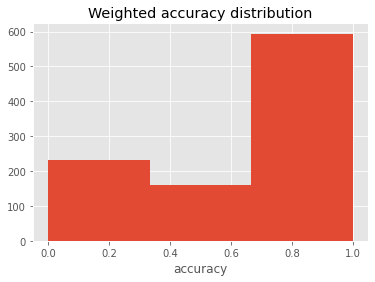

In [0]:
plt.style.use('ggplot')

plt.hist(model_acc_list, bins=np.linspace(0,1,num=4))
plt.title("Weighted accuracy distribution")
plt.xlabel("accuracy")
plt.show()

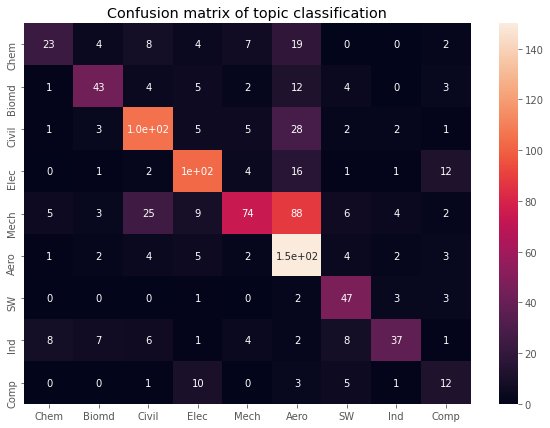

In [0]:
doc_utils.plotConfMatrix(test_labels, predictions, model="Similarity")

### Using binary accuracy

In [0]:
predictions, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="binary")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model binary accuracy over 984 test documents: 59.34959349593496%.


In [0]:
#Same confusion matrix as before.

In [0]:
doc_utils.plotConfMatrix(test_labels, predictions, model="Similarity")

#Model fine tuning

We want to improve the 
* 59.4% pure accuracy
* 68% weighted accuracy 

That baseline was achieved with no hyperparameter tuning whatsoever and no complex text processing done over input documents.

## Step 1: Performing micro-analysis of documents prone to errors

We want to take a look over those documents (can be seen on the confusion matrix) which categories are prone to fail classification. We can first take a look on their corresponding topic definition, and / or over the specific query articles. 

We want to (or may) look for the following issues that may be causing misclassification:
* Short topic definitions 
* Short query articles
* "Dirty" documents containing unnecesary / garbage words.

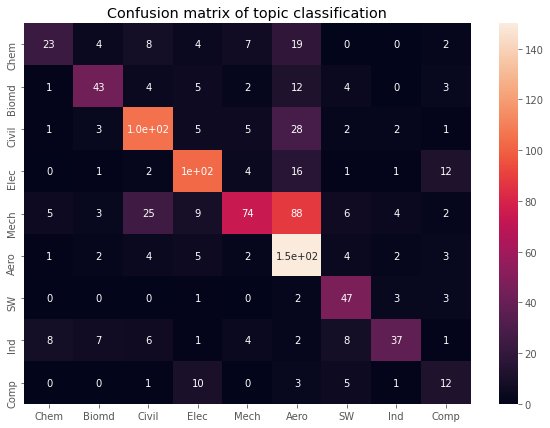

In [0]:
doc_utils.plotConfMatrix(test_labels, predictions, model="Similarity")

There are a lot of predictions which fall onto the "Aerospace Engineering" topic, so it affects misclassifications over mainly the topics of "Electrcal, Civil, Chem and Biomd" engineerings. This is probably due to the fact that Aeroespace Engineering articles have many samples (around 175), 150 of those are correctly classified. This could happen because the topic definition of aerospace engineering is shorter and includes concepts that may be confused with the other engineerings. Aerospace engineering is contained within the Mechanical engineering field, and thus those misclassified articles makes sense.

In [0]:
#Looking at topic definition lengths
wiki_topic_defs_full

In [0]:
print("Preprocessed text information:\n")
for topic in wiki_topic_defs_full:
    print(" ".join(topic.split(" ")[:2])+" --> topic definition length (nchars):\t"+str(len(topic))+"; n_Words:\t"+str(len(topic.split(" "))))

Preprocessed text information:

Chemical engineering --> topic definition length (nchars):	11101; n_Words:	1577
Biomedical engineering --> topic definition length (nchars):	33221; n_Words:	4659
Civil engineering --> topic definition length (nchars):	22982; n_Words:	3182
Electrical engineering --> topic definition length (nchars):	43195; n_Words:	5998
Mechanical engineering --> topic definition length (nchars):	33991; n_Words:	4838
Aerospace engineering --> topic definition length (nchars):	11303; n_Words:	1594
Software engineering --> topic definition length (nchars):	19910; n_Words:	2751
Industrial engineering --> topic definition length (nchars):	16616; n_Words:	2293
Computer engineering --> topic definition length (nchars):	13129; n_Words:	1804


Chemical and Aerospace engineerings have short topic definitions, thus we could expect low accuracy on those 2 topics.


In [0]:
for i, topic in enumerate(wiki_test_data):
    print(doc_utils.ENG_TOPICS_ABVR[i]+"-related total articles:\t"+str(len(topic[0])))

Chem-related total articles:	67
Biomd-related total articles:	74
Civil-related total articles:	152
Elec-related total articles:	140
Mech-related total articles:	216
Aero-related total articles:	173
SW-related total articles:	56
Ind-related total articles:	74
Comp-related total articles:	32


Let's take a look now on the **processed tokens** of the topic definitions, to see how well constructed are and how their lengths have varied

In [0]:
train_corpus

In [0]:
for i in [0,1,2,3,4,5]:
    print(test_corpus[i])

It seems that we have many words that can be discarded. So lets try to create a better text processing function, instead of the "*gensim.utils.simple_preprocess()*" that is currently used in "*prepare_corpus()*"

## Trying to improve text preprocessing

In [0]:
from gensim.utils import simple_preprocess

In [0]:
simple_preprocess 

<function gensim.utils.simple_preprocess>

In [0]:
#Looking at Gensim function source code:
#https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess
def simple_preprocess(doc, deacc=False, min_len=2, max_len=15):
    """
    Convert a document into a list of tokens.

    This lowercases, tokenizes, de-accents (optional). -- the output are final
    tokens = unicode strings, that won't be processed any further.

    """
    tokens = [
        token for token in tokenize(doc, lower=True, deacc=deacc, errors='ignore')
        if min_len <= len(token) <= max_len and not token.startswith('_')
    ]
    return tokens
#As we can see, it only performs a really basic tokenization with no stemming/lemmatization
# or stopword, punctuation removal, etc.

Let's try to improve it

In [0]:
doc= "Chemical engineering is a branch of engineering that uses principles of chemistry, physics, mathematics, biology, and economics to efficiently use, produce, design, transport and transform energy and materials. The work of chemical engineers can range from the utilisation of nano-technology and nano-materials in the laboratory to large-scale industrial processes that convert chemicals, raw materials, living cells, microorganisms, and energy into useful forms and products.\nChemical engineers are involved in many aspects of plant design and operation, including safety and hazard assessments, process design and analysis, modeling, control engineering, chemical reaction engineering, nuclear engineering, biological engineering,  construction specification, and operating instructions."

In [0]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
tokenized_doc=word_tokenize(doc)
lemmatized_doc = [lemmatizer.lemmatize(word) for word in tokenized_doc]
lemmatized_doc= [word for word in lemmatized_doc if word.isalnum()]
lemmatized_nostopw_doc= [word.lower() for word in lemmatized_doc if word.isalnum() and not word in stop_words]

It seems that achieve our desired result, so let's make a custom preprocess function to include it into the "prepare_corpus()" function:

In [0]:
#Dependencies
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download
download('punkt')
download('wordnet')
download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

def custom_preprocess(doc):
    tokenized_doc=word_tokenize(doc)
    lemmatized_doc = [lemmatizer.lemmatize(word) for word in tokenized_doc]
    #lemmatized_doc= [word for word in lemmatized_doc if word.isalnum()]
    lemmatized_nostopw_doc= [word.lower() for word in lemmatized_doc if word.isalnum() and not word in stop_words]

    return lemmatized_nostopw_doc

## Testing model with new processing

In [0]:
train_corpus = list(doc_utils.prepare_corpus(wiki_topic_defs_full, preprocess='complex'))
test_corpus = list(doc_utils.prepare_corpus(wiki_test_data,preprocess='complex' ,train_data=False))

In [0]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [0]:
predictions, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="weighted")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model weighted accuracy over 984 test documents: 68.34349593495935%.


We do not seem to have a significative improvement over the accuracy

In [0]:
predictions, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="binary")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model binary accuracy over 984 test documents: 60.36585365853659%.


## Step 2: Model hyperparameter tuning

Doc2Vec Model Hyperparameters: [source](https://radimrehurek.com/gensim/models/doc2vec.html)
    

```
gensim.models.doc2vec.Doc2Vec(documents=None, corpus_file=None, dm_mean=None, dm=1,
                            dbow_words=0, dm_concat=0, dm_tag_count=1, docvecs=None, 
            docvecs_mapfile=None, comment=None, trim_rule=None, callbacks=(), **kwargs)
```
which is an extension from the base class:
```
class gensim.models.base_any2vec.BaseWordEmbeddingsModel(sentences=None, corpus_file=None, 
                        workers=3, vector_size=100, epochs=5, callbacks=(), batch_words=10000, 
                        trim_rule=None, sg=0, alpha=0.025, window=5, seed=1, hs=0, negative=5, ns_exponent=0.75, 
                        cbow_mean=1, min_alpha=0.0001, compute_loss=False, **kwargs)
```
* **documents** (iterable of list of TaggedDocument, optional) – Input corpus, can be simply a list of elements, but for larger corpora,consider an iterable that streams the documents directly from disk/network. If you don’t supply documents (or corpus_file), the model is left uninitialized – use if you plan to initialize it in some other way.

* **corpus_file** (str, optional) – Path to a corpus file in LineSentence format. You may use this argument instead of documents to get performance boost. Only one of documents or corpus_file arguments need to be passed (or none of them, in that case, the model is left uninitialized). Documents’ tags are assigned automatically and are equal to line number, as in TaggedLineDocument.

* **dm** ({1,0}, optional) – Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.

* **vector_size** (int, optional) – Dimensionality of the feature vectors.

* **window** (int, optional) – The maximum distance between the current and predicted word within a sentence.

* **alpha** (float, optional) – The initial learning rate.

* **min_alpha** (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

* **seed** (int, optional) – Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). Note that for a fully deterministically-reproducible run, you must also limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization.

* **min_count** (int, optional) – Ignores all words with total frequency lower than this.

* **max_vocab_size** (int, optional) – Limits the RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. Every 10 million word types need about 1GB of RAM. Set to None for no limit.

* **sample** (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

* **workers** (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).

* **epochs** (int, optional) – Number of iterations (epochs) over the corpus.

* **hs** ({1,0}, optional) – If 1, hierarchical softmax will be used for model training. If set to 0, and negative is non-zero, negative sampling will be used.

* **negative** (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

* **ns_exponent** (float, optional) – The exponent used to shape the negative sampling distribution. A value of 1.0 samples exactly in proportion to the frequencies, 0.0 samples all words equally, while a negative value samples low-frequency words more than high-frequency words. The popular default value of 0.75 was chosen by the original Word2Vec paper. More recently, in https://arxiv.org/abs/1804.04212, Caselles-Dupré, Lesaint, & Royo-Letelier suggest that other values may perform better for recommendation applications.

* **dm_mean** ({1,0}, optional) – If 0 , use the sum of the context word vectors. If 1, use the mean. Only applies when dm is used in non-concatenative mode.

* **dm_concat** ({1,0}, optional) – If 1, use concatenation of context vectors rather than sum/average; Note concatenation results in a much-larger model, as the input is no longer the size of one (sampled or arithmetically combined) word vector, but the size of the tag(s) and all words in the context strung together.

* **dm_tag_count** (int, optional) – Expected constant number of document tags per document, when using dm_concat mode.

* **dbow_words** ({1,0}, optional) – If set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW doc-vector training; If 0, only trains doc-vectors (faster).






### Rough grid search

In [0]:
#Standard grid search procedure
grid=[{"epochs": 10,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 10,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 10,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 10,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 30,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 30,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 30,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 30,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 50,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 50,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 50,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 50,"min_count": 1,"vector_size":100,"acc":""}
      ]

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [0]:
grid_predictions = list()
grid_accs = list()

for elem in grid:
    model = gensim.models.doc2vec.Doc2Vec(vector_size=elem["vector_size"], 
                                          min_count=elem["min_count"], 
                                          epochs=elem["epochs"])

    model.build_vocab(train_corpus)
    print("Training and evaluating model with params:",elem)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    model_preds, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="weighted")

    grid_predictions.append(model_preds)
    elem["acc"] = np.mean(model_acc_list) * 100
    grid_accs.append(model_acc_list)


Training and evaluating model with params: {'epochs': 10, 'min_count': 1, 'vector_size': 25, 'acc': ''}


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model weighted accuracy over 984 test documents: 38.46544715447154%.
Training and evaluating model with params: {'epochs': 10, 'min_count': 1, 'vector_size': 50, 'acc': ''}
Model weighted accuracy over 984 test documents: 40.65040650406504%.
Training and evaluating model with params: {'epochs': 10, 'min_count': 1, 'vector_size': 75, 'acc': ''}
Model weighted accuracy over 984 test documents: 42.47967479674797%.
Training and evaluating model with params: {'epochs': 10, 'min_count': 1, 'vector_size': 100, 'acc': ''}
Model weighted accuracy over 984 test documents: 40.853658536585364%.
Training and evaluating model with params: {'epochs': 30, 'min_count': 1, 'vector_size': 25, 'acc': ''}
Model weighted accuracy over 984 test documents: 58.790650406504064%.
Training and evaluating model with params: {'epochs': 30, 'min_count': 1, 'vector_size': 50, 'acc': ''}
Model weighted accuracy over 984 test documents: 58.58739837398373%.
Training and evaluating model with params: {'epochs': 30, 'min_

In [0]:
grid2=[{"epochs": 60,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 80,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 80,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 80,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 80,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 125,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 125,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 125,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 125,"min_count": 1,"vector_size":100,"acc":""},
      {"epochs": 150,"min_count": 1,"vector_size":25,"acc":""},
      {"epochs": 150,"min_count": 1,"vector_size":50,"acc":""},
      {"epochs": 150,"min_count": 1,"vector_size":75,"acc":""},
      {"epochs": 150,"min_count": 1,"vector_size":100,"acc":""}
      ]

In [0]:
grid_predictions = list()
grid_accs = list()

for elem in grid2:
    model = gensim.models.doc2vec.Doc2Vec(vector_size=elem["vector_size"], 
                                          min_count=elem["min_count"], 
                                          epochs=elem["epochs"])

    model.build_vocab(train_corpus)
    print("Training and evaluating model with params:",elem)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    model_preds, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="weighted")

    grid_predictions.append(model_preds)
    elem["acc"] = np.mean(model_acc_list) * 100
    grid_accs.append(model_acc_list)

Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 25, 'acc': ''}


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model weighted accuracy over 984 test documents: 66.0060975609756%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 50, 'acc': ''}
Model weighted accuracy over 984 test documents: 65.4979674796748%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 75, 'acc': ''}
Model weighted accuracy over 984 test documents: 66.0060975609756%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 100, 'acc': ''}
Model weighted accuracy over 984 test documents: 65.8028455284553%.
Training and evaluating model with params: {'epochs': 70, 'min_count': 1, 'vector_size': 25, 'acc': ''}
Model weighted accuracy over 984 test documents: 64.1260162601626%.
Training and evaluating model with params: {'epochs': 70, 'min_count': 1, 'vector_size': 50, 'acc': ''}
Model weighted accuracy over 984 test documents: 64.22764227642277%.
Training and evaluating model with params: {'epochs': 70, 'min_count':

In [0]:
grid3=[{"epochs":60,"min_count": 1,"vector_size":125,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":150,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":175,"acc":""},
      {"epochs": 60,"min_count": 1,"vector_size":200,"acc":""},
      {"epochs":70,"min_count": 1,"vector_size":125,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":150,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":175,"acc":""},
      {"epochs": 70,"min_count": 1,"vector_size":200,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":125,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":150,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":175,"acc":""},
      {"epochs": 90,"min_count": 1,"vector_size":200,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":125,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":150,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":175,"acc":""},
      {"epochs": 100,"min_count": 1,"vector_size":200,"acc":""},
      ]

In [0]:
grid_predictions = list()
grid_accs = list()

for elem in grid3:
    model = gensim.models.doc2vec.Doc2Vec(vector_size=elem["vector_size"], 
                                          min_count=elem["min_count"], 
                                          epochs=elem["epochs"])

    model.build_vocab(train_corpus)
    print("Training and evaluating model with params:",elem)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    model_preds, model_acc_list = doc_utils.evaluate_model(model, test_corpus, test_labels, eval="weighted")

    grid_predictions.append(model_preds)
    elem["acc"] = np.mean(model_acc_list) * 100
    grid_accs.append(model_acc_list)

Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 125, 'acc': ''}


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Model weighted accuracy over 984 test documents: 66.20934959349594%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 150, 'acc': ''}
Model weighted accuracy over 984 test documents: 65.85365853658537%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 175, 'acc': ''}
Model weighted accuracy over 984 test documents: 66.3109756097561%.
Training and evaluating model with params: {'epochs': 60, 'min_count': 1, 'vector_size': 200, 'acc': ''}
Model weighted accuracy over 984 test documents: 66.05691056910568%.
Training and evaluating model with params: {'epochs': 70, 'min_count': 1, 'vector_size': 125, 'acc': ''}
Model weighted accuracy over 984 test documents: 64.02439024390245%.
Training and evaluating model with params: {'epochs': 70, 'min_count': 1, 'vector_size': 150, 'acc': ''}
Model weighted accuracy over 984 test documents: 64.53252032520325%.
Training and evaluating model with params: {'epochs': 70, 'min

In [0]:
#todo: play with "alpha" parameter?